# PeTar Data Analysis Sample

This sample demonstrates a basic usage of the data analysis module in Python. Users can find additional information about the data analysis module in the README on the PeTar GitHub page.

To utilize the data analysis module, users should first import `petar` and other essential modules for data analysis.

In [1]:
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Users can duplicate the sample scripts located in the `sample` directory, specifically those named `star_cluster*.sh`, to a new directory of their choice. Depending on whether SSE/BSE and Galpy are enabled or not, the reading method requires different keyword arguments. Below, three distinct scenarios are presented to illustrate this.

# Pure Gravity Scenario

Upon executing the script `star_cluster.sh` to generate a star cluster model, it is essential to specify the path to this directory in the following steps.

In [2]:
# path to the simulation directory
path='/home/lwang/localdata/N1kb/'

## Reading Snapshots

Use `petar.PeTarDataHeader` to read the header line of snapshot, when snapshot is ASCII format:

In [3]:
filename = 'data.25'
header = petar.PeTarDataHeader(path+filename)
print('Time',header.time, '\nN',header.n, '\nFile ID',header.file_id)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lwang/localdata/N1kb/data.25'

Use `petar.Particle` to read the particle information in the snapshot. The first line is skiped.

In [ ]:
particle = petar.Particle()
particle.loadtxt(path+filename,skiprows=1)

Use `calcR2` to calculate distance of particles to the center and plot the density profile

In [ ]:
fig, axes=plt.subplots(1,1)
# calculat R2
particle.calcR2()
# calculate R
r = np.sqrt(particle.r2)
# plot histogram of r
axes.hist(r, bins=np.logspace(0,3,50))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('R')
axes.set_ylabel('Count')

## Plot the positions of stars

To plot positions of stars in the x-y plane, where the colors of the points indicate the stellar mass.

In [ ]:
import matplotlib.colors as colors

fig, axes=plt.subplots(1,1)
x = particle.pos[:,0]
y = particle.pos[:,1]
pt = axes.scatter(x, y, s=1, cmap='hot', norm=colors.LogNorm(vmin=0.08, vmax=150), c=particle.mass)
cb = plt.colorbar(pt)
cb.set_label('Mass')
axes.set_aspect(1)
axes.set_xlabel('x')
axes.set_ylabel('y')

## Making Selection

Create a subset of particles with distance to the cluter center < 10

In [ ]:
# calculate the cluster distance square
particle.calcR2()

# make selection
sel = (particle.r2 < 100) 

# create a subset of data
subset = particle[sel]

Plot positions of stars in the x-y plane with distances < 10 

In [ ]:
import matplotlib.colors as colors

fig, axes=plt.subplots(1,1)

x = subset.pos[:,0]
y = subset.pos[:,1]
pt = axes.scatter(x, y, s=1, cmap='hot', norm=colors.LogNorm(vmin=0.08, vmax=150), c=subset.mass)
cb = plt.colorbar(pt)
cb.set_label('Mass')
axes.set_aspect(1)
axes.set_xlabel('x')
axes.set_ylabel('y')

## Printing Data in a Table

Use `printTable` function, users can select the members to print with specified format. The following samples print the mass, x, y, z of the first 10 members in the subset of particles.

In [ ]:
subset[:10].printTable([('mass','%10.5g'),('pos[0]','%20.14g'),('pos[1]','%20.14g'),('pos[2]','%20.14g')])

## Reading Binary Snapshots

Use `petar.Binary` to read binary snapshots generated by `petar.data.process`

In [ ]:
binary = petar.Binary(member_particle_type=petar.Particle, G=petar.G_MSUN_PC_MYR)
binary.loadtxt(path+'data.25.binary')

## Plot semi-ecc distribution

To plot the distribution of semi-major axes versus eccentricities of binaries, where colors represent mass ratio and sizes represent masses.

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(4, 4),dpi=150) 
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3]) 

axexy = fig.add_subplot(gs[1,0])
axehx = fig.add_subplot(gs[0,0],sharex=axexy)
axehy = fig.add_subplot(gs[1,1],sharey=axexy)
axehx.get_xaxis().set_visible(False)
axehy.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.02,wspace=0.02)

xlim=[0.1,1e4]
ylim=[0,0.999]
axexy.set_xlim(*xlim)
axexy.set_ylim(*ylim)
axehx.set_xscale('log')
axexy.set_xlabel(r'Semi-major axes [AU]',fontsize=12)
axexy.set_ylabel(r'eccentricity',fontsize=12)

nbinx=30
nbiny=30
log_xbins=np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbinx)
ybins=np.linspace(ylim[0], ylim[1], nbiny)

x = binary.semi*206265
y = binary.ecc
m1 = binary.p1.mass
m2 = binary.p2.mass
mass_ratio = np.minimum(m1,m2)/np.maximum(m1,m2)

axehx.hist(x, bins=log_xbins,histtype='step',color='grey',
           weights=np.ones(x.size)/x.size,label='Initial')
axehy.hist(y, bins=ybins,histtype='step',orientation="horizontal",color='grey',
           weights=np.ones(x.size)/x.size)
pt = axexy.scatter(x ,y, s=binary.mass, c=mass_ratio)
cbaxes = fig.add_axes([0.95,0.15,0.02,0.7]) 
cb = plt.colorbar(pt, cax = cbaxes)  
cb.set_label('mass ratio')

## Reading Lagrangian Properites

Use `petar.LagrangianMultiple` to read the Lagrangian properties of the star cluster generated by `petar.data.process`:

In [ ]:
lagr = petar.LagrangianMultiple()
lagr.loadtxt(path+'data.lagr')

Plot the evolution of core radius and Lagrangian radii

In [ ]:
fig, axes=plt.subplots(1,1)
for i in range(5):
    axes.plot(lagr.time, lagr.all.r[:,i], '-',label=lagr.initargs['mass_fraction'][i])

axes.plot(lagr.time, lagr.all.r[:,-1],'--',label='Rc')
axes.set_xlabel('Time')
axes.set_ylabel('R')
axes.legend(loc='upper right')
axes.set_yscale('log')

## Reading Group Information

By utilizing `petar.GroupInfo`, users can access details regarding the formation and dissolution of various systems, including binaries, triples, quadruples, and more. Upon employing `petar.data.gether -g data`, the group information is saved in files such as `data.group.n2`, `data.group.n3`, where the number denotes the count of members in the multiple systems. The following example demonstrates how to read the groups file and analyze the information.

In [ ]:
# load two-body groups (binary, hyperbolic encounters)
g2 = petar.GroupInfo(N=2)
g2.loadtxt(path+'data.group.n2')

# load 3-body 
g3 = petar.GroupInfo(N=3)
g3.loadtxt(path+'data.group.n3')

# load 4-body
g4 = petar.GroupInfo(N=4)
g4.loadtxt(path+'data.group.n4')

Display a table illustrating the 3-body system, where 'bin0' denotes the outer pair and 'bin1' signifies the inner pair. The center of mass of the inner pair is one of the members of the outer pair. The ID of the center of mass particle is the lower of the two inner member IDs.

In [ ]:
g3.printTable([('bin0.m1','%10.4f'),('bin0.m2','%10.4f'),
               ('bin0.p1.id','%11d'),('bin0.p2.id','%11d'),
               ('bin0.semi','%10.4g'),('bin0.ecc','%10.4g'),
               ('bin1.m1','%10.4f'),('bin1.m2','%10.4f'),
               ('bin1.p1.id','%11d'),('bin1.p2.id','%11d'),
               ('bin1.semi','%10.4g'),('bin1.ecc','%10.4g')])

# Scenario with Stellar Evolution (SSE/BSE)

This section explains how to analyze a star cluster simulation that incorporates SSE/BSE. Users can utilize the `star_cluster_bse.sh` script to create a sample model of this nature.

In [ ]:
# path to the simulation directory
path='/home/lwang/localdata/N1kb_bse/'

## Reading Snapshots

Use `petar.Particle` to read the particle information in the snapshot, and include `interrupt_mode='bse'` to specify that SSE/BSE is activated during the compilation of PeTar. It is important to note that even if the stellar evolution option is disabled when using `petar`, but SSE/BSE is compiled, this argument is still required. Additionally, remember to skip the first line when reading the data.

In [ ]:
particle = petar.Particle(interrupt_mode='bse')
particle.loadtxt(path+'data.25',skiprows=1)

## Ploting HR Diagram

With SSE/BSE enabled, it becomes feasible to generate an HR diagram of stars, showcasing different stellar types with distinct colors. Below is an example demonstrating how to accomplish this task.

Notice that the temperature is not directly stored in the dataset but can be computed using the following method.

In [ ]:
# luminosity
lum = particle.star.lum
# calculate temperature
temp = 5778*(particle.star.lum/(particle.star.rad*particle.star.rad))**0.25

# plot HR diagram
import matplotlib.colors as colors
fig, axes = plt.subplots(1,1)
norm = colors.BoundaryNorm(boundaries=np.arange(16), ncolors=256)
pt = axes.scatter(temp, lum, c=particle.star.type, cmap='rainbow', norm=norm)
cb = plt.colorbar(pt)
cb.set_label('SSE stellar type')
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_xlabel('Temperature')
axes.set_ylabel('Luminosity')
axes.set_xlim(30000, 1000)
axes.set_ylim(1e-5, 1e6)

## Reading Stellar Evolution Events

When stars or binaries changes types, PeTar record the properties in event files. The follow scripts show how to read these event files generated by `petar.data.process`.

In [ ]:
# type change of stars
sse_type=petar.SSETypeChange()
sse_type.loadtxt(path+'data.sse.type_change')

# supernova kicks of single stars
sse_kick=petar.SSESNKick()
sse_kick.loadtxt(path+'data.sse.sn_kick')

# type change of binaries
bse_type=petar.BSETypeChange()
bse_type.loadtxt(path+'data.bse.type_change')

# supernova kicks in binaries
bse_kick=petar.BSESNKick()
bse_kick.loadtxt(path+'data.bse.sn_kick')

# dynamically driven mergers of hyperbolic encounters
bse_dyn=petar.BSEDynamicMerge()
bse_dyn.loadtxt(path+'data.bse.dynamic_merge')

Print Events in a Table

In [ ]:
bse_type.printTable([('type','%4d'),('init.time','%10g'),('init.type1','%11d'),('init.type2','%11d'),
                     ('init.m1','%9f'),('init.m2','%9f'),('init.semi','%10g'),('init.ecc','%9f'),
                     ('final.type1','%12d'),('final.type2','%12d'),('final.m1','%9f'),('final.m2','%9f'),
                     ('final.semi','%11g'),('final.ecc','%10g')])

## Gather Merger Events

Use `petar.BSEMerge`, users can gather the information of binary and hyperbolic mergers from binary type change and dynamical merger events. Below is an example demonstrating how to accomplish this task.

Please be aware that in some cases, supernova events in binaries can completely disrupt a star, leaving no remnant behind. Such occurrences may mistakenly be classified as mergers. Therefore, the merger events identified here are considered 'candidates'. It is recommended to examine the evolutionary history of these mergers to confirm whether they are indeed true mergers.

In [ ]:
merger = petar.BSEMerge()
# Gather events
merger.combine(bse_type, bse_dyn)

# Print information of mergers
merger.printTable()

## Gather Specified Objects

Using `petar.get.object.snap`, users can scan a list of snapshots and gather specified objects into a single file with a time sequence based on selected single/binary IDs, stellar types, mass regions, or user-defined selection functions. For instance, after applying `petar.data.gether` and `petar.data.process`, running this tool to gather all binary main sequence stars (BMSs) in a simulation can be done with the following command:

```
petar.get.object.snap -i bse -f binary -m type MS MS data.snap.lst
```

In this command, `data.snap.lst` represents the snapshot list generated by `petar.data.gether`. Executing this command will create a new file named `object.MS.MS.binary`, which contains all BMSs detected in the snapshots.

To read this file, a similar approach to reading binary snapshots generated by `petar.data.process` is required, with the addition of a new member `time` that needs to be included before reading.

In [ ]:
bms = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', G=petar.G_MSUN_PC_MYR)
bms.addNewMember('time', np.array([]).astype(float))
bms.loadtxt(path+'object.MS.MS.binary')

With the retrieved data, we can visualize the evolution of binary parameters, such as the semi-major axes of all BMS.

In [ ]:
fig, axes = plt.subplots(1,1)
pt = axes.scatter(bms.time, bms.semi, c=bms.mass, s=2)
cb = plt.colorbar(pt)
cb.set_label(r'mass [$M_\odot$]')
axes.set_yscale('log')
axes.set_xlabel('Time [Myr]')
axes.set_ylabel('semi-major axes [pc]')

As another example, we collect the data of a star with ID = 1 from original snapshots generated by `petar` using the command:
```
petar.get.object.snap -i bse -f origin -m id 1 data.snap.lst
```
The resulting output file is named `object.1`.
The method for reading this file is akin to reading single and original snapshot files, with the addition of the new member `time`.

In [ ]:
p1 = petar.Particle(interrupt_mode='bse')
p1.addNewMember('time', np.array([]).astype(float))
p1.loadtxt(path+'object.1')

Next, we plot the trajectory of particle 1 in the x-y plane:

In [ ]:
fig, axes = plt.subplots(1,1)
axes.plot(p1.pos[:,0],p1.pos[:,1],'-',c='grey')
pt = axes.scatter(p1.pos[:,0], p1.pos[:,1], c=p1.time)
cb = plt.colorbar(pt)
cb.set_label(r'time [Myr]')
axes.set_xlabel('x [pc]')
axes.set_ylabel('y [pc]')
axes.set_aspect(1)

# Scenario with SSE/BSE and Galpy

This section explains how to analyze a star cluster simulation that incorporates SSE/BSE and Galactic potential (Galpy). Users can use the `star_cluster_bse_galpy.sh` script to create a sample model of this nature.

In [ ]:
# path to the simulation directory
path='/home/lwang/localdata/N1kb_bse_galpy/'

## Reading the Cluster Center Position and Velocity

When using the Galactic potential, the coordinate system center in the simulation is aligned with the Galactic center. The header of snapshots contains information about the position and velocity of the cluster potential center, and all particle coordinates are relative to this center. The script below reads the header, and the `pos_offset` and `vel_offset` variables indicate the center position and velocity.

In [ ]:
header = petar.PeTarDataHeader(path+'data.25',external_mode='galpy')

In [ ]:
print('Center position:',header.pos_offset, '\nCenter velocity:', header.vel_offset)

## Reading Snapshots 

Use `petar.Particle` to read the particle information in the snapshot, and include `interrupt_mode='bse' external_mode=galpy` to specify that SSE/BSE and Galpy is activated during the compilation of PeTar. It is important to note that even if the stellar evolution option is disabled or no external potential is enabled when using `petar`, but SSE/BSE and Galpy are both compiled, this argument is still required. Additionally, remember to skip the first line when reading the data.

In [ ]:
particle = petar.Particle(interrupt_mode='bse', external_mode='galpy')
particle.loadtxt(path+'data.25',skiprows=1)

## Converting to Astropy SkyCoord Data Type

The `astropy.SkyCoord` module offers a robust coordinate conversion method that can be useful for converting simulation data into observational coordinate systems like ICRS. By utilizing the `toSkyCoord` method, you can convert the header and snapshot data into the `SkyCoord` format:

In [ ]:
center_sc = header.toSkyCoord()
snap_sc = particle.toSkyCoord(pos_offset=header.pos_offset, vel_offset=header.vel_offset)

Get the position and velocity in ICRS frame

In [ ]:
# print center in ICRS frame
print(center_sc.icrs)
# print first 10 particles in ICRS frame
print(snap_sc[:10].icrs)

## Plotting RA-Dec and Proper Motion

With the SkyCoord format, plotting RA-Dec and Proper Motion of stars becomes straightforward. The following example selects stars within 10 parsecs from the cluster center and visualizes their RA-Dec and Proper Motion distribution. Stellar types are distinguished by colors, and star sizes correspond to their masses.

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(4,6))

# select stars based on distance
particle.calcR2()
r = np.sqrt(particle.r2)
sel = (r<30)

# RA-Dec
norm = colors.BoundaryNorm(boundaries=np.arange(16), ncolors=256)
pt1 = axes[0].scatter(snap_sc.icrs.ra[sel], snap_sc.icrs.dec[sel], s = particle.mass[sel], c=particle.star.type[sel], cmap='rainbow', norm=norm)
cbaxes = fig.add_axes([0.95, 0.15, 0.03, 0.7]) 
cb = plt.colorbar(pt1, cax = cbaxes)  
cb.set_label('SSE stellar type')
axes[0].set_xlabel('RA')
axes[0].set_ylabel('Dec')

# Proper Motion
axes[1].scatter(snap_sc.icrs.pm_ra_cosdec[sel], snap_sc.icrs.pm_dec[sel], s = particle.mass[sel], c=particle.star.type[sel], cmap='rainbow', norm=norm)
axes[1].set_xlabel('pm_RA_cosdec')
axes[1].set_ylabel('pm_Dec')


# Scenario for Few-Body Systems

## Using status file to record snapshots

When the number of objects is small, such as 1 or 2 in total, the `-w 2` option in the `petar` command can be used. This allows PeTar to record the snapshots of objects directly inside the status file, instead of generating individual snapshot files. This approach is particularly convenient for plotting the time evolution of individual objects.

For example, consider a single Sun-like object orbiting within the Milky Way potential at a distance of 8 kpc from the center, moving at a speed of 220 km/s. We can create an input data file named `input.base` with the following content:

```
1 8000 0 0 0 224.996676310053 0
```

Next, we use `petar.init` to initialize the `input` file and then run the simulation for about 1000 Myr using `petar`. The commands are as follows:

```bash
petar.init -t galpy -f input input.base
OMP_NUM_THREADS=1 petar -u 1 -s 0.125 -o 1 --galpy-set MWPotential2014 -t 1000 -w 2 input &> output &
```

Here, only the `galpy` module is enabled during the configuration of PeTar.

By using the `-w 2` option, PeTar does not generate individual snapshot files such as `data.0`, `data.1`, etc. Instead, all snapshot information is saved in the `data.status` file.

This file can then be read using `petar.Status`, allowing us to plot the orbits of the single object in a straightforward way. Note that the `external_mode` and `interrupt_mode` options should match the configuration settings used when compiling PeTar. Additionally, the `N_particle` parameter should be set to indicate the total number of objects in the simulation.

In [10]:
# path to the simulation directory
path='/home/lwang/localdata/petar_test/one/'

In [13]:
status = petar.Status(external_mode='galpy', N_particle=1)
status.loadtxt(path+'data.status')

Using the `status` file, we can plot the orbit of the single object. The particle information is stored in `status.particles.p[index]`, where `index` indicates the particle number, starting from 0. When there is only one particle, you can directly use `p0`. 

The following code demonstrates how to plot the orbit in the x-y plane (a circle orbit):

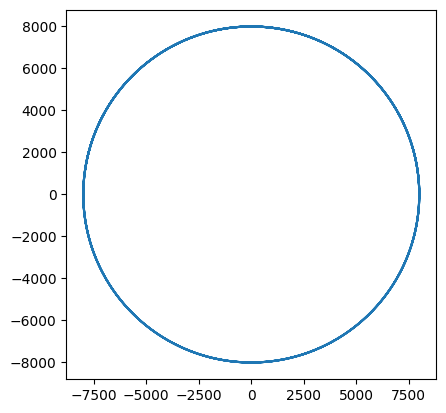

In [16]:
fig, axes = plt.subplots(1,1)
pos = status.particles.p0.pos
axes.plot(pos[:,0], pos[:,1])
axes.set_aspect(1)